In [1]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import clean_trials, get_timestamps_from_rec, get_recording_time,plot_probe, assign_DIO_times_to_trials, Trim_TTLs, select_DIO_sync_trial_trace, stitch_bpod_times, select_DIO_channel, find_min_distance_TTL, call_trodesexport, check_single_rec_file, check_timestamps_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
from spikeinterface.sorters import run_sorter
from spikeinterface.preprocessing import detect_bad_channels
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.patches as mpatches
import panel as pn
from tqdm.notebook import tqdm

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

In [2]:
# TODO:
# check gaps mouse 12 20240126
# check gaps mouse 13 20231212
# check timestamps.dat == spikeinterface times

# **Ott lab process single session**
#####  Multi-Neuropixels recording using SpikeGadgets + Bpod

## Imperative folder structure:

- /n_animal
  - /ephys (it has to be called like this)
    - 20240126_184212.rec
    - 20240221_184222.rec
  - /bpod_session (it has to be called like this)
    - 20240126_184212
    - 20240221_184212

# Select file

In [9]:
# folder containing .rec file
path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec")
#path_recording_folder = Path(r"O:\data\12\ephys\20240126_184212.rec")

mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)
time = get_recording_time(path_recording_folder)
print(f"mouse {mouse_n} recorded on {day} at {time}")

path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

mouse 12 recorded on 20240126 at 18:42:12
Exactly one .rec file found: 20240126_184212.rec


## Extract timestamps from .rec file

In [10]:
%%time
# We adjust timestamps using the timestamps extracted from the .rec file. spikeinterface assumes no gaps (see https://spikeinterface.readthedocs.io/en/latest/modules_gallery/core/plot_6_handle_times.html) and hides all gaps in the recording.

timestamps = get_timestamps_from_rec(path_recording_folder,  path_recording)

Found 1 timestamps.dat files
Read timestamps from /alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat
CPU times: user 160 ms, sys: 1.85 s, total: 2.01 s
Wall time: 2.01 s


## Load recording in spikeinterface

In [11]:
%%time

raw_rec = read_spikegadgets(path_recording)

fs = raw_rec.get_sampling_frequency()

correct_times = timestamps/fs
raw_rec.set_times(correct_times) # set new times, RIGHT NOW IT DOES NOT PROPAGATE TO SORTING OBJECT and AFTER SAVING TO DISK!

print(f"Recording duration in minutes: {raw_rec.get_total_duration()/60}, sampling rate: {fs} Hz")
print(f"Probes present: {raw_rec.get_probes()}")

Recording duration in minutes: 124.70285666666668, sampling rate: 30000.0 Hz
Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]
CPU times: user 399 ms, sys: 1.07 s, total: 1.47 s
Wall time: 1.47 s


In [12]:
gaps_start_stop = check_timestamps_gaps(raw_rec, correct_times)

Gap from 3241.0439 to 3241.0918, duration 0.0479 s
Gap from 3241.0924333333332 to 3241.171566666667, duration 0.079133 s
Gap from 3241.1722 to 3241.2519, duration 0.0797 s
Gap from 3241.2525333333333 to 3241.3317, duration 0.079167 s
Gap from 3241.3323333333333 to 3241.4114666666665, duration 0.079133 s
Gap from 3241.4121 to 3241.4917666666665, duration 0.079667 s
Gap from 3241.4924 to 3241.5715333333333, duration 0.079133 s
Gap from 3241.572166666667 to 3241.6518333333333, duration 0.079667 s
Gap from 3241.6524666666664 to 3241.7316333333333, duration 0.079167 s
Gap from 3241.732266666667 to 3241.8114333333333, duration 0.079167 s
Gap from 3241.812066666667 to 3241.8818666666666, duration 0.0698 s
Gap from 3241.8825 to 3241.9055333333336, duration 0.023033 s


# Sync Bpod and Trodes streams

### Export Digital IO channels

In [13]:
%%time
#check if already available, if not extract
call_trodesexport(path_recording_folder, path_recording, "dio")

.DIO folder alread available: 20240126_184212.DIO
CPU times: user 441 µs, sys: 132 µs, total: 573 µs
Wall time: 634 µs


In [14]:
DIO_timestamps_start_trial, DIO_samples_start_trial = select_DIO_sync_trial_trace(path_recording_folder, rec_file_name)

20240126_184212.dio_Controller_Din1.dat contains data
1 DIO files with data


## Load bpod mat file behavior

In [15]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , path_recording_folder, raw_rec)

.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20240126_184341/12_AuditoryTuning_20240126_184341.mat
Bpod file starts within the Trodes recording
.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20240126_185807/12_DetectionConfidence_20240126_185807.mat
Bpod file starts within the Trodes recording


## Stitch trials and trim as needed

/alzheimer/Roberto/Dariya/12/bpod_session/20240126_184341/12_AuditoryTuning_20240126_184341.mat
Bpod session started at 18:43:46, duration: 12.810576666666666 min, ended at: 18:56:34
number trials: 600
Extracting AuditoryTuning params
/alzheimer/Roberto/Dariya/12/bpod_session/20240126_185807/12_DetectionConfidence_20240126_185807.mat
Bpod session started at 18:58:27, duration: 107.21848833333334 min, ended at: 20:45:40
number trials: 704
Extracting DetectionConfidence params
CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 336 ms


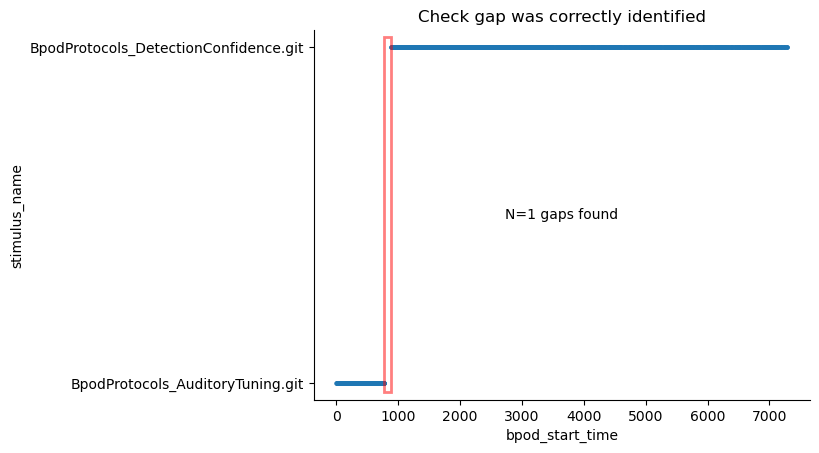

In [17]:
%%time
# currently can deal only with 2 behavior files, no more!
trials =  stitch_bpod_times(bpod_file, day, DIO_timestamps_start_trial)

len DIO:1305, len Bpod:1304
The most distant pulse in array1 is at index 1304 with time 7300.312333333333
This pulse has a minimum distance of 12.191267013549805 to the closest pulse in array2


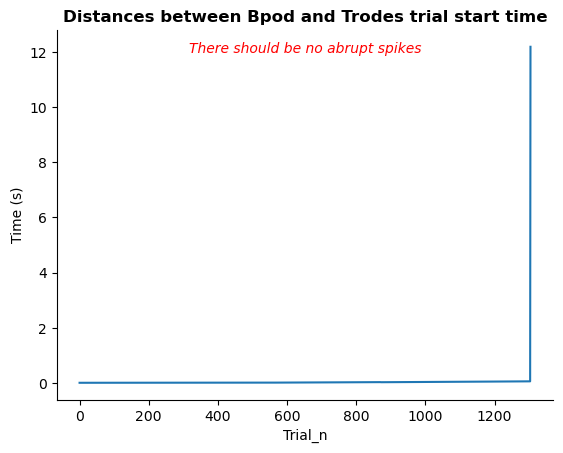

In [18]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

In [19]:
# only adapted to case where there is a extra TTL in the DIO at the end of last stimulus block!
DIO_timestamps_start_trial,  DIO_samples_start_trial = Trim_TTLs(trials, DIO_timestamps_start_trial, DIO_samples_start_trial,min_distances)

unequal numbers of trials between bpod and DIO
One extra TTL pulse received on DIO at the end of the session
extra TTL pulse removed


len DIO:1304, len Bpod:1304
The most distant pulse in array1 is at index 1303 with time 7288.173633333334
This pulse has a minimum distance of 0.05256666615605354 to the closest pulse in array2


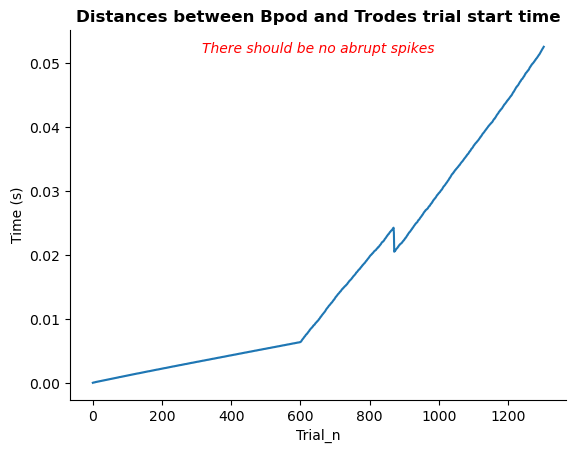

In [20]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

CPU times: user 16.9 ms, sys: 245 µs, total: 17.1 ms
Wall time: 15.5 ms


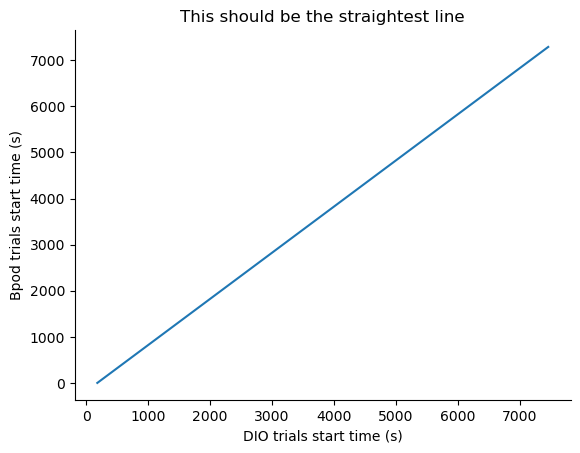

In [21]:
%%time
trials = assign_DIO_times_to_trials(trials, DIO_timestamps_start_trial, DIO_samples_start_trial)

## Final Trial df

In [22]:
%%time
cleaned_trials = clean_trials(trials, raw_rec, gaps_start_stop)

No trials discarded
CPU times: user 35.1 ms, sys: 871 µs, total: 35.9 ms
Wall time: 33.7 ms


In [23]:
cleaned_trials.to_csv(Path(f"{path_recording_folder}/trials.csv"))

In [24]:
pd.read_csv(Path(f"{path_recording_folder}/trials.csv"))

,trial_n,bpod_start_time,bpod_stop_time,stimulus_block,stimulus_name,frequency,volume,after_trial_interval,before_trial_interval,beta,...,reward_start_time,d_i_o_start_sample,d_i_o_start_time,d_i_o_start_sample_zeroed,start_time,duration,stop_time,has_gap,reward_start_time_absolute,stimulus_start_time_absolute
0,0,1.182500,2.382500,0,BpodProtocols_AuditoryTuning.git,500.0,60.0,NaN,NaN,NaN,...,NaN,5263146,175.438200,0,0.000000,1.2000,1.200000,False,NaN,NaN
1,1,2.494000,3.694000,0,BpodProtocols_AuditoryTuning.git,1000.0,60.0,NaN,NaN,NaN,...,NaN,5302492,176.749733,39346,1.311533,1.2000,2.511533,False,NaN,NaN
2,2,3.754300,4.954300,0,BpodProtocols_AuditoryTuning.git,1500.0,60.0,NaN,NaN,NaN,...,NaN,5340301,178.010033,77155,2.571833,1.2000,3.771833,False,NaN,NaN
3,3,5.015300,6.215300,0,BpodProtocols_AuditoryTuning.git,2000.0,60.0,NaN,NaN,NaN,...,NaN,5378131,179.271033,114985,3.832833,1.2000,5.032833,False,NaN,NaN
4,4,6.272700,7.472700,0,BpodProtocols_AuditoryTuning.git,2500.0,60.0,NaN,NaN,NaN,...,NaN,5415854,180.528467,152708,5.090300,1.2000,6.290300,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1299,7240.733867,7246.617667,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.830212,...,NaN,222451253,7415.041767,217188107,7240.591700,5.8838,7246.475500,False,NaN,NaN
1300,1300,7252.913467,7258.797267,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,-0.055047,...,NaN,222816644,7427.221467,217553498,7252.771400,5.8838,7258.655200,False,NaN,NaN
1301,1301,7265.035067,7270.918867,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.925595,...,NaN,223180294,7439.343133,217917148,7264.893067,5.8838,7270.776867,False,NaN,NaN
1302,1302,7277.177267,7283.061067,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,-0.544914,...,NaN,223544563,7451.485433,218281417,7277.035367,5.8838,7282.919167,False,NaN,NaN


# Spike sorting

## Pre-processing

### Detect bad channels

In [ ]:
%%time
if os.path.exists(f"{path_recording_folder}/channel_labels.csv"):
    channel_labels = pd.read_csv(f"{path_recording_folder}/channel_labels.csv")
else:
    bad_channel_ids_list = [] 
    channel_labels_list = []
    channel_ids_list = []
    # detect noisy, dead, and out-of-brain channels
    split_preprocessed_recording = raw_rec.split_by("group")
    for group, sub_rec in tqdm(split_preprocessed_recording.items()):
        bad_channel_ids, channel_labels = detect_bad_channels(sub_rec)
                
        bad_channel_ids_list.append(bad_channel_ids)
        channel_labels_list.extend(channel_labels)
        channel_ids_list.extend(sub_rec.channel_ids)
     
    channel_labels = pd.DataFrame([channel_ids_list, channel_labels_list], index=["channel_ids", "channel_labels"]).T
    channel_labels.to_csv(f"{path_recording_folder}/channel_labels.csv", index=False)

bad_channel_ids = channel_labels[~(channel_labels["channel_labels"] == "good")]["channel_ids"].values

In [130]:
# count bad channels

print(channel_labels["channel_labels"].value_counts())

channel_labels
dead    622
good    146
Name: count, dtype: int64


### Inspect probes

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] Matplotlib(Figure, design=<class 'panel.theme.bootst...)
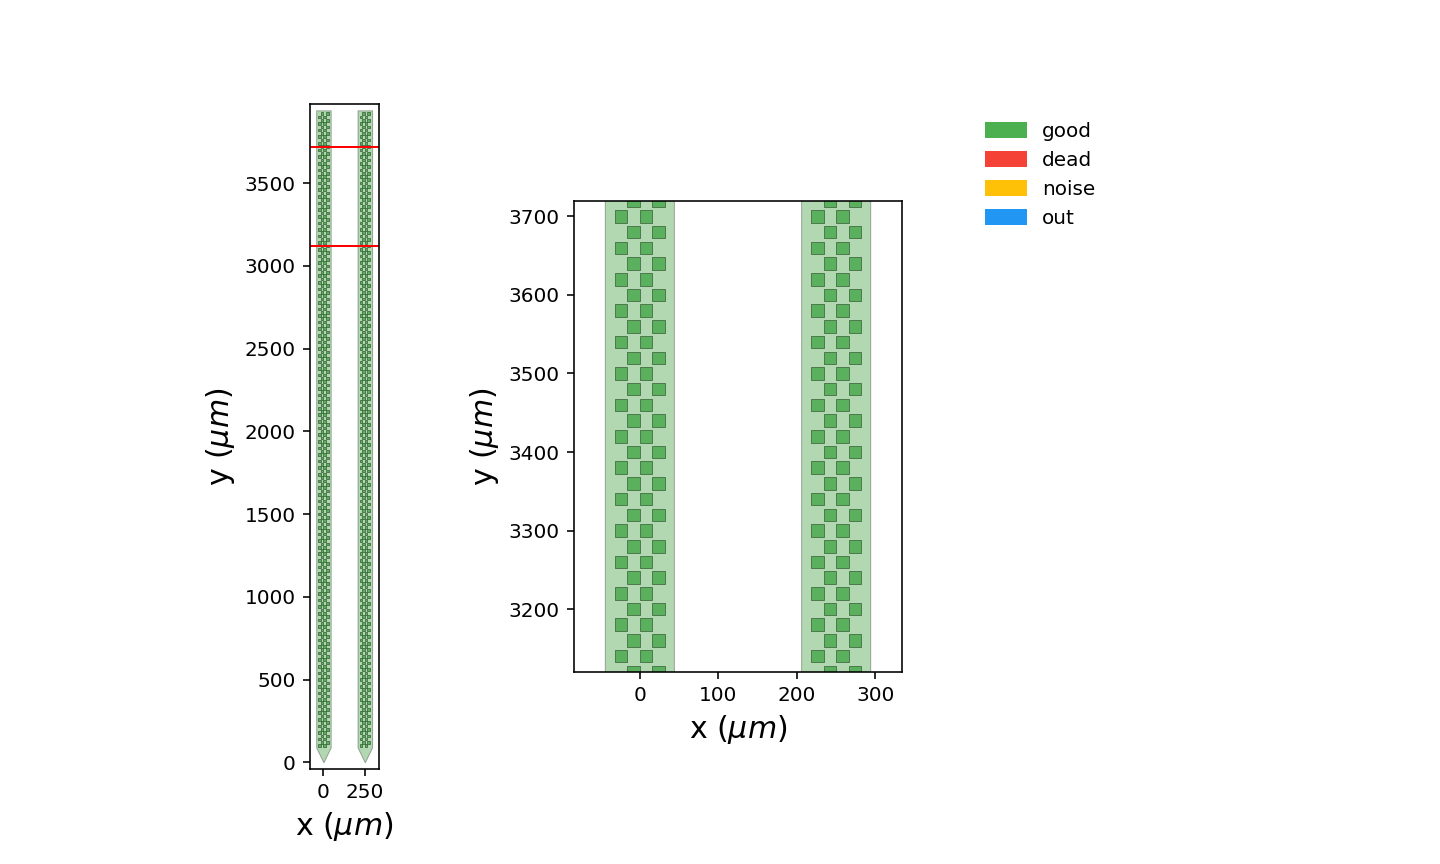

In [94]:
plot_probe(raw_rec, channel_labels["channel_labels"].values)

In [95]:
# remove bad channels
raw_rec = raw_rec.remove_channels(bad_channel_ids)
print(f"{len(bad_channel_ids)} bad channels removed")

0 bad channels removed


## Sorting

In [23]:
%%time

check_gpu_availability()

torch.cuda.empty_cache()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.60s; total  7.60s

computing drift
Re-computing universal templates from data.


  4%|█████████▋                                                                                                                                                                                                                    | 23/530 [00:22<08:26,  1.00it/s]

KeyboardInterrupt



Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7efe7c080f70>> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



# Post-processing

## Manual curation with Phy

### Add custom metrics in phy

In [33]:
from spikeinterface.core import write_binary_recording
from Utils.Settings import job_kwargs
from Utils.Paths import conda_path
from spikeinterface import create_sorting_analyzer
from spikeinterface.sorters import read_sorter_folder

In [17]:
%%time
# TODO check this
split_preprocessed_recording = raw_rec.split_by("group")

for group, sub_rec in split_preprocessed_recording.items():
    write_binary_recording( sub_rec, file_paths=f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/recording.dat", **job_kwargs)

    params_path = Path(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/params.py")
    
    # modify params.py to point at .dat file extracted
    with open(params_path, 'r') as file:
        lines = file.readlines()
    
    with open(params_path, 'w') as file:
        file.writelines(['dat_path = r\'recording.dat\'\n' if line.startswith('dat_path =') else line for line in lines])

    sorting = read_sorter_folder(f"{path_recording_folder}/spike_interface_output/probe{group}")
    #sorting = read_phy(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/")

    # compute 'isi_violation', 'presence_ratio' to add to phy
    analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="memory", **job_kwargs)

    analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                  "templates": dict(),
                   "noise_levels":dict(),
                  "quality_metrics": dict(metric_names=['isi_violation', 'presence_ratio'])})
    
    metrics = analyzer.get_extension('quality_metrics').get_data()
    metrics.index.name="cluster_id"
    metrics.reset_index(inplace=True)
    #create .tsv files in sorter_output folder
    for metric in ['isi_violations_ratio', 'presence_ratio']:
        metrics[["cluster_id", metric]].to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_{metric}.tsv", sep="\t", index=False)

    # Use ks labels as default
    kslabels = pd.read_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_KSLabel.tsv", sep="\t")
    kslabels.rename(columns={"KSLabel": "group"}, inplace=True)
    kslabels.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_group.tsv", sep="\t", index=False)

estimate_sparsity:   0%|          | 0/36 [00:00<?, ?it/s]

estimate_templates_with_accumulator:   0%|          | 0/1059 [00:00<?, ?it/s]

estimate_sparsity:   0%|          | 0/36 [00:00<?, ?it/s]

estimate_templates_with_accumulator:   0%|          | 0/1059 [00:00<?, ?it/s]

CPU times: user 5min 20s, sys: 1min 4s, total: 6min 24s
Wall time: 7min 55s


### Open phy

In [27]:
#select_probe
group = 0

In [240]:
sorter_path = f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output"  # Set your path here

! source $conda_path && conda activate phy2 && cd $sorter_path && phy template-gui params.py


12:41:41.279 [W] model:1408           File recording.dat does not exist.
12:41:41.563 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
12:41:41.567 [W] traces:462           File /alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/spike_interface_output/probe1/sorter_output/recording.dat does not exist.
12:41:41.568 [W] traces:462           File /alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/spike_interface_output/probe1/sorter_output/recording.dat does not exist.
12:41:54.043 [W] gui:671              Could not create view TraceView.
[1271537:7:0430/124156.694685:ERROR:command_buffer_proxy_impl.cc(141)] ContextResult::kTransientFailure: Failed to send GpuChannelMsg_CreateCommandBuffer.
[1271538:7:0430/124156.695245:ERROR:command_buffer_proxy_impl.cc(141)] ContextResult::kTransientFailure: Failed to send GpuChannelMsg_CreateCommandBuffer.
12:42:08.631 [I] supervisor:700       Merge clusters 0, 1

# Calculate metrics on selected clusters

In [28]:
from spikeinterface.extractors import read_phy
from spikeinterface import create_sorting_analyzer, load_sorting_analyzer
from spikeinterface.qualitymetrics import compute_quality_metrics, get_quality_metric_list, get_quality_pca_metric_list
from spikeinterface.sorters import read_sorter_folder
from spikeinterface.postprocessing import compute_template_metrics
from spikeinterface.exporters import export_to_phy
from spikeinterface.core import write_binary_recording

In [29]:
sorting = read_phy(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/")

In [31]:
analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="binary_folder",  **job_kwargs, 
                                   folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer") # job params propagate

analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                  "waveforms":  dict(ms_before=1,ms_after=2.),
                  'spike_amplitudes':dict(),
                 "templates": dict(operators=["average", "std"]),
                 "noise_levels":dict(), 
                 'correlograms':dict() ,
                 'unit_locations':dict(method="monopolar_triangulation"),
                 'template_similarity':dict(),
                 "template_metrics":dict(include_multi_channel_metrics=True),
                 "spike_locations":dict(),
                 "quality_metrics": dict(metric_names=get_quality_metric_list())})

#analyzer.compute("principal_components", **job_kwargs)

metrics = pd.concat([analyzer.get_extension('quality_metrics').get_data(), analyzer.get_extension("template_metrics").get_data()], axis=1)# add template metrics

np.testing.assert_array_equal(analyzer.unit_ids ,  metrics.index)

metrics["probe_n"] = f"probe{group}"
metrics.index.name= "unit_id"
metrics.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/metrics")

NameError: name 'sub_rec' is not defined

In [ ]:
%%time

# Here we calculate the following metrics: ['num_spikes','firing_rate','presence_ratio','snr','isi_violation','rp_violation','sliding_rp_violation','amplitude_cutoff','amplitude_median','amplitude_cv','synchrony','firing_range','drift','sd_ratio']
 
split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items(): # we do this on single probes, save space!

    print(f"Processing probe{group}")
    
    try:
        sorting = read_phy(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/") # this will be updated with merges and split
    except:
        print("problem with read_phy, fall on read_sorter_folder")
        sorting = read_sorter_folder(f"{path_recording_folder}/spike_interface_output/probe{group}/") # not including merges and split
    
    analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="binary_folder",  **job_kwargs, 
                                       folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer") # job params propagate

    analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                      "waveforms":  dict(ms_before=1,ms_after=2.),
                      'spike_amplitudes':dict(),
                     "templates": dict(operators=["average", "std"]),
                     "noise_levels":dict(), 
                      'correlograms':dict() ,
                     'unit_locations':dict(method="monopolar_triangulation"),
                     'template_similarity':dict(),
                     "template_metrics":dict(include_multi_channel_metrics=True),
                     "spike_locations":dict(),
                     "quality_metrics": dict(metric_names=get_quality_metric_list())})

    #analyzer.compute("principal_components", **job_kwargs)
    
    metrics = pd.concat([analyzer.get_extension('quality_metrics').get_data(), analyzer.get_extension("template_metrics").get_data()], axis=1)# add template metrics

    np.testing.assert_array_equal(analyzer.unit_ids,  metrics.index)# check ids are updatd after phy curation
    
    metrics["probe_n"] = f"probe{group}"
    metrics.index.name= "unit_id"
    metrics.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/metrics")
    
    # TODO order extensions to be checked

Processing probe0


estimate_sparsity:   0%|          | 0/250 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/7483 [00:00<?, ?it/s]

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/scipy/stats/_stats_mst

Compute : spike_amplitudes + spike_locations:   0%|          | 0/7483 [00:00<?, ?it/s]

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/sortingcomponents/peak_localization.py:215: RuntimeWarning: divide by zero encountered in divide
  coms = np.dot(wf_data, local_contact_locations) / (np.sum(wf_data, axis=1)[:, np.newaxis])
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/sortingcomponents/peak_localization.py:215: RuntimeWarning: invalid value encountered in divide
  coms = np.dot(wf_data, local_contact_locations) / (np.sum(wf_data, axis=1)[:, np.newaxis])


In [185]:
#si.get_template_extremum_amplitude(analyzer)

In [186]:
#pd.DataFrame(analyzer.get_channel_locations())

In [187]:
#si.get_template_extremum_channel(analyzer, outputs="index")

In [188]:
#analyzer.get_channel_locations()

No gaps detected.


# Trash

### Export Analog IO channels

In [160]:
%%time
extract_analogIO(path_recording_folder, path_recording)# 55 min too slow


'.analog' folder alread available: 20231212_183552.analog
CPU times: user 553 µs, sys: 109 µs, total: 662 µs
Wall time: 770 µs


### Export timestamps

In [161]:
%%time
#extract_time(path_recording_folder, path_recording) # slower than analogIO somehow!!

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


## Load Trodes timestamps

In [174]:
path_analogIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.analog")

In [521]:
from Utils.TrodesToPython.readTrodesExtractedDataFile3 import readTrodesExtractedDataFile, get_Trodes_timestamps
analog_dict = readTrodesExtractedDataFile(Path(path_analogIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.timestamps.dat"))

NameError: name 'path_analogIO_folder' is not defined

In [178]:
analog_dict["data"].shape

(277320457,)

In [179]:
raw_rec.get_total_samples()

277320457

In [640]:
%%time
kilosort_timestamp2 = get_Trodes_timestamps(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat"))

CPU times: user 849 µs, sys: 467 ms, total: 468 ms
Wall time: 465 ms


In [643]:
kilosort_timestamp2

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [187]:
analog_dict["data"]["time"]

array([  1279032,   1279033,   1279034, ..., 278599486, 278599487,
       278599488], dtype=uint32)

In [641]:
%%time
kilosort_timestamp = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat"))

CPU times: user 0 ns, sys: 452 ms, total: 452 ms
Wall time: 449 ms


In [638]:
kilosort_timestamp["data"]["time"]

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [671]:
analog_timestamp = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestampsanalog.dat"))

In [608]:
np.unique(np.diff(analog_timestamp["data"]["time"]))

array([   1,    2,    3,  691, 1437, 2094, 2374, 2375, 2390, 2391],
      dtype=uint32)

In [609]:
np.unique(np.diff(kilosort_timestamp["data"]["time"]))

array([   1,    2,    3,  691, 1437, 2094, 2374, 2375, 2390, 2391],
      dtype=uint32)

In [539]:
np.unique(np.diff(raw_rec.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05])

In [601]:
raw_rec.get_times()

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       7.48217130e+03, 7.48217133e+03, 7.48217137e+03])

In [604]:
(analog_timestamp["data"]["time"]- analog_timestamp["data"]["time"][0]) / 30000.0

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       7.48315943e+03, 7.48315947e+03, 7.48315950e+03])

In [513]:
analog_timestamp["data"]["time"]

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [655]:
%%time
t=readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/20231212_183552.analog/20231212_183552.analog_Headstage_GyroX.dat"))

CPU times: user 3.59 ms, sys: 1.66 s, total: 1.66 s
Wall time: 6.6 s


In [670]:
path_timestamps = find_file("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/", "timestamps.dat")
path_timestamps

Found 1 timestamps.dat files


['/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/20231212_183552.analog/20231212_183552.timestamps.dat']

In [666]:
path_timestamps

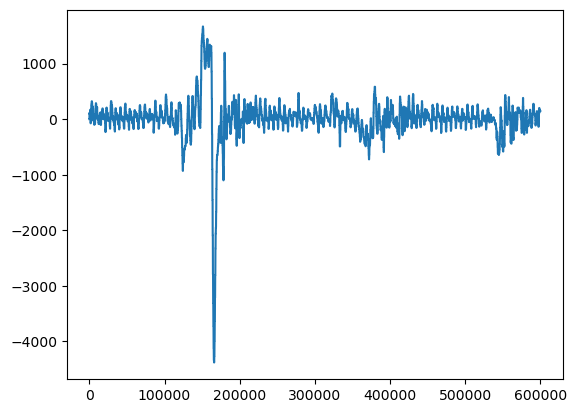

In [657]:
plt.plot(t["data"]["voltage"][:30000*20])

In [38]:
import spikeinterface.full as si

In [103]:
sorting = si.read_sorter_folder(f"/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/spike_interface_output/probe1/")

In [123]:
split_preprocessed_recording = raw_rec.split_by("group")

In [124]:
split_preprocessed_recording[0].get_time_info()

{'sampling_frequency': 30000.0,
 't_start': None,
 'time_vector': array([  10.        ,   10.00003333,   10.00006667, ..., 7493.15943333,
        7493.15946667, 7493.1595    ])}

In [52]:
np.unique(np.diff(sorting.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05])

In [49]:
sorting.register_recording(raw_rec)

In [50]:
np.unique(np.diff(sorting.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05,
       6.66666665e-05, 6.66666666e-05, 6.66666667e-05, 6.66666667e-05,
       6.66666667e-05, 6.66666667e-05, 6.66666667e-05, 6.66666670e-05,
       6.66666674e-05, 9.99999993e-05, 9.99999997e-05, 1.00000000e-04,
       1.00000000e-04, 2.30333333e-02, 4.79000000e-02, 6.98000000e-02,
       7.91333333e-02, 7.91333333e-02, 7.91666667e-02, 7.91666667e-02,
       7.96666667e-02, 7.97000000e-02])

In [95]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface import aggregate_channels
from probeinterface import generate_tetrode, ProbeGroup
import numpy as np

# Create a toy 384 channel recording with 4 shanks (each shank contain 96 channels)
recording, _ = se.toy_example(duration=[16.00], num_segments=1, num_channels=384)
four_shank_groupings = np.repeat([0, 1, 2, 3], 96)
recording.set_property("group", four_shank_groupings)

print(recording.get_channel_groups())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [96]:
times = recording.get_times()

In [97]:
times

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       1.59999000e+01, 1.59999333e+01, 1.59999667e+01])

In [98]:
recording.set_times(times+10)

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/core/baserecording.py:429: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated across preprocessingUse this carefully!
  warn(


In [99]:
recording.get_times()

array([10.        , 10.00003333, 10.00006667, ..., 25.9999    ,
       25.99993333, 25.99996667])

In [100]:
split_recordings_dict = recording.split_by("group")

In [101]:
 preprocessed_recordings = []

# loop over the recordings contained in the dictionary
 for chan_group_rec in split_recordings_dict.values():

     filtered_recording = spre.bandpass_filter(chan_group_rec)

     referenced_recording = spre.common_reference(filtered_recording)

     preprocessed_recordings.append(referenced_recording)

 # Combine our preprocessed channel groups back together
 combined_preprocessed_recording = aggregate_channels(preprocessed_recordings)

In [ ]:
split_preprocessed_recording =  combined_preprocessed_recording.split_by("group")

sortings = {}
for group, sub_recording in split_preprocessed_recording.items():
    sorting = run_sorter(
        sorter_name='kilosort4',
        recording=sub_recording,
        output_folder=f"folder_KS2_group{group}"
        )
    sortings[group] = sorting

In [131]:
sorting.get_times()

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       1.59999000e+01, 1.59999333e+01, 1.59999667e+01])

In [130]:
split_preprocessed_recording[0].get_times()

array([10.        , 10.00003333, 10.00006667, ..., 25.9999    ,
       25.99993333, 25.99996667])

## save space

In [41]:
analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer_allchan/")
analyzer

SortingAnalyzer: 768 channels - 278 units - 1 segments - binary_folder - sparse - has recording
Loaded 10 extensions: spike_amplitudes, waveforms, unit_locations, template_similarity, templates, template_metrics, random_spikes, noise_levels, correlograms, quality_metrics

In [42]:
analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer/")
analyzer

SortingAnalyzer: 384 channels - 278 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extensions: spike_amplitudes, template_similarity, random_spikes, templates, spike_locations, unit_locations, noise_levels, correlograms, waveforms, template_metrics, quality_metrics